In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import interpolation
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import AxesGrid

Text(0.5, 1.0, 'Trotter gradient with threshold')

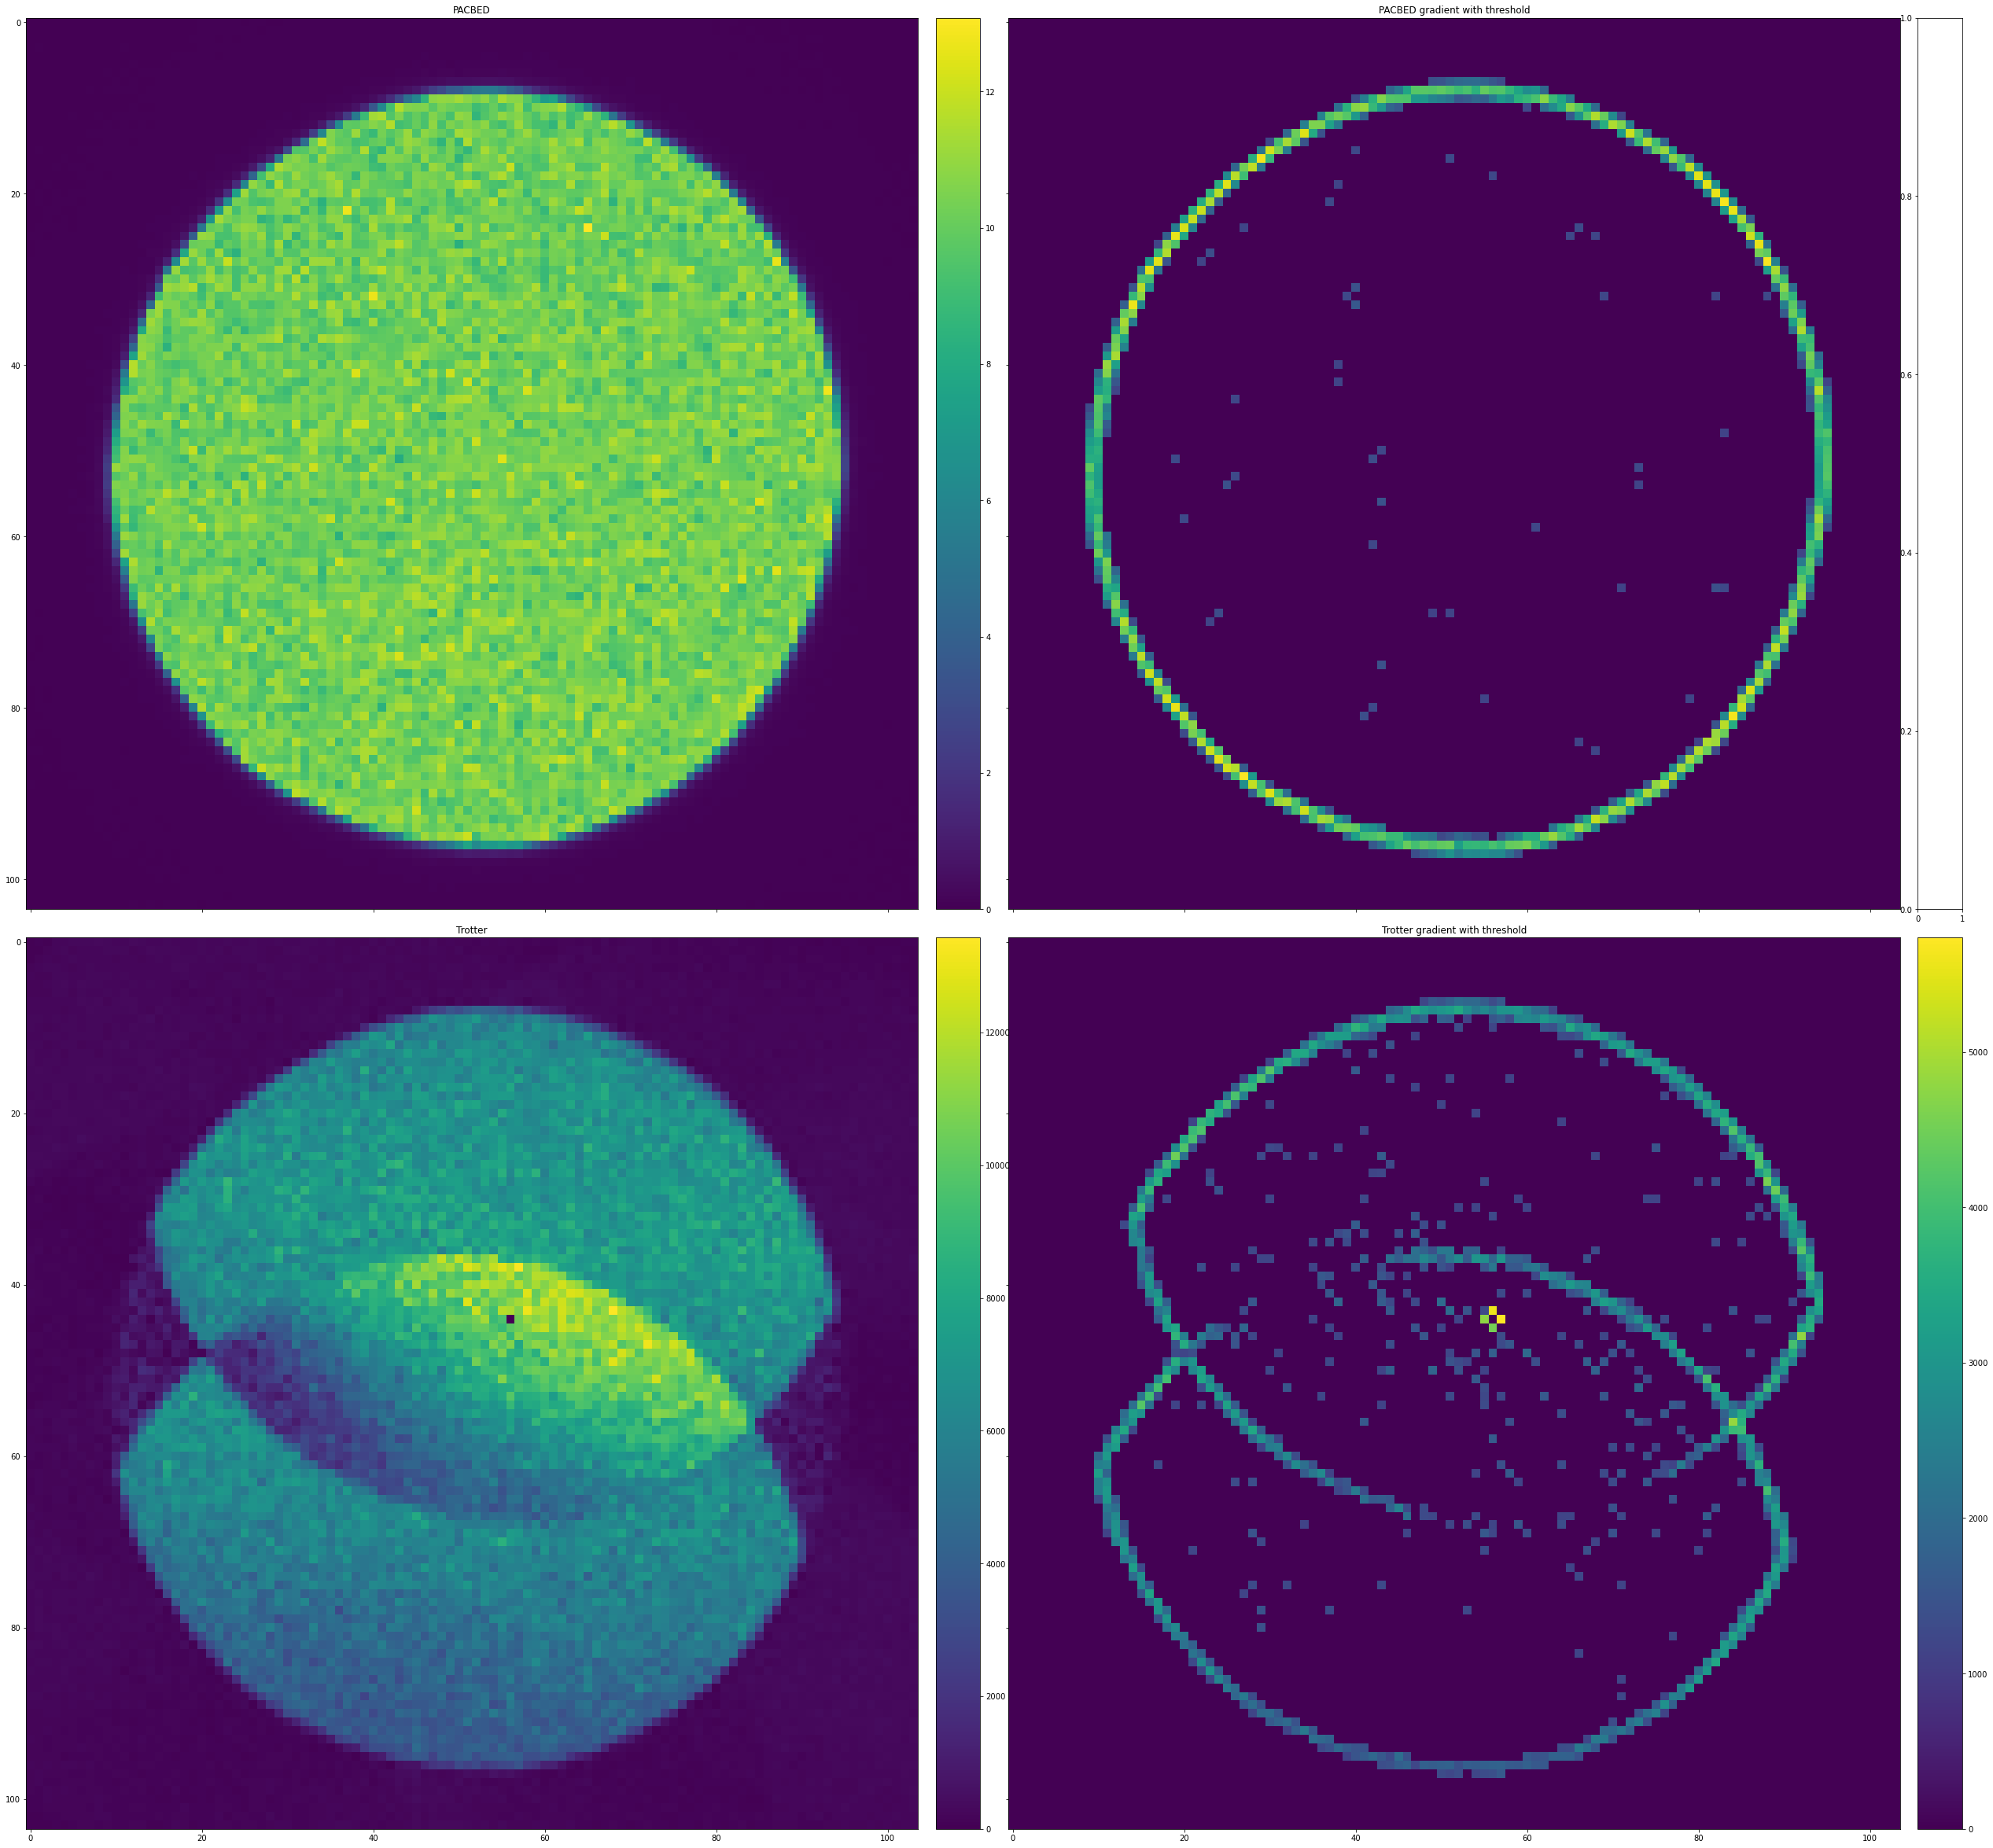

In [2]:
thresh = 0.20
pacbed = np.load("pacbed trim.npy")
slices = np.load("trotter intensity.npy")
pacbed_grad = np.sqrt(np.sum(np.square(np.gradient(pacbed)), axis = 0))
slices_grad = np.sqrt(np.sum(np.square(np.gradient(slices)), axis = 0))
pacbed_grad[np.where(pacbed_grad < np.max(pacbed_grad)*thresh)] = 0
slices_grad[np.where(slices_grad < np.max(slices_grad)*thresh)] = 0
#slices_grad[np.where(pacbed_grad > np.max(pacbed_grad)*thresh)] = 0
fig =plt.figure(1, figsize=(150, 150))
grid=AxesGrid(fig, 236, nrows_ncols=(2,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("PACBED")
im=grid[1].imshow(pacbed_grad, cmap=plt.cm.viridis)
grid[1].set_title("PACBED gradient with threshold")
im=grid[2].imshow(slices, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Trotter")
im=grid[3].imshow(slices_grad, cmap=plt.cm.viridis)
grid.cbar_axes[3].colorbar(im)
grid[3].set_title("Trotter gradient with threshold")

In [3]:
def ShiftDisk(frame,dx,dy):
    expanded = np.zeros((frame.shape[0]*5,frame.shape[1]*5), frame.dtype)
    expanded[2*frame.shape[0]:3*frame.shape[0],2*frame.shape[1]:3*frame.shape[1]]=frame
    reci_frame=np.fft.fftshift(np.fft.fft2(expanded))
    x_start = -int(expanded.shape[1]/2)
    y_start = -int(expanded.shape[0]/2)
    x_end = x_start + expanded.shape[1]
    y_end = y_start + expanded.shape[0]
    X, Y = np.meshgrid(np.arange(x_start, x_end),np.arange(y_start,y_end))
    X=X*(1.0/expanded.shape[1])
    Y=Y*(1.0/expanded.shape[0])
    reci_frame=reci_frame*np.exp(-2j*np.pi*(dx*X+dy*Y))
    expanded = np.real(np.fft.ifft2(np.fft.ifftshift(reci_frame)))
    return expanded[2*frame.shape[0]:3*frame.shape[0],2*frame.shape[1]:3*frame.shape[1]]
def GradMaximizer(params, gradt, pacbed_grad):
    dist = params[0]
    angle = params[1]
    disk1 = ShiftDisk(pacbed_grad, dist*np.cos(angle), dist*np.sin(angle))
    disk2 = ShiftDisk(pacbed_grad,-dist*np.cos(angle),-dist*np.sin(angle))
    mask = np.where((disk1 > np.max(pacbed_grad)*thresh) | (disk2 > np.max(pacbed_grad)*thresh))
    grad_temp = np.abs(gradt)
    grad_temp[mask] = 0.0
    return np.sum(grad_temp)

In [4]:
trotter_params = np.asarray([29.6, -1.44])
trotter_params = optimize.minimize(GradMaximizer, trotter_params, args=(slices_grad, pacbed_grad), method='Nelder-Mead').x
print(trotter_params)

[28.79448669 -1.44262079]


In [5]:
def CircleTarget(params, grad, gridY, gridX):
    radius = params[2]
    x_center = params[0]
    y_center = params[1]
    masked_grad = grad.copy()
    #generate a 2D frame for this center. 
    radius_map = np.sqrt((gridX - x_center)**2 + (gridY - y_center)**2)
    radial_mask = np.zeros_like(grad)
    radial_mask[np.where(radius_map<=radius)] = 1.0
    radial_mask=np.sqrt(np.sum(np.square(np.abs(np.gradient(radial_mask))), axis =0))
    masked_grad[np.where(radial_mask > 0.15)] = 0.0
    #return the total error.
    return np.sum(masked_grad)
#treat the aperture as a oval shape, and determine the angle from the oval.
def OvalTarget(params, grad, gridY, gridX):
    x_center = params[0]
    y_center = params[1]
    radius = params[2]
    gama = params[3]
    angle = params[4]
    masked_grad = grad.copy()
    #generate a 2D frame for this center.
    gradX_temp = (gridX - x_center)*np.cos(angle) - (gridY - y_center)*np.sin(angle)
    gradY_temp = (gridX - x_center)*np.sin(angle) + (gridY - y_center)*np.cos(angle)
    radius_map = np.sqrt(gradX_temp**2 + (gama*gradY_temp)**2)
    radial_mask = np.zeros_like(grad)
    radial_mask[np.where(radius_map<=radius)] = 1.0
    radial_mask=np.sqrt(np.sum(np.square(np.abs(np.gradient(radial_mask))), axis =0))
    masked_grad[np.where(radial_mask > thresh)] = 0.0
    #return the total error.
    return np.sum(masked_grad)

Text(0.5, 1.0, 'PACBED with Apeture outline')

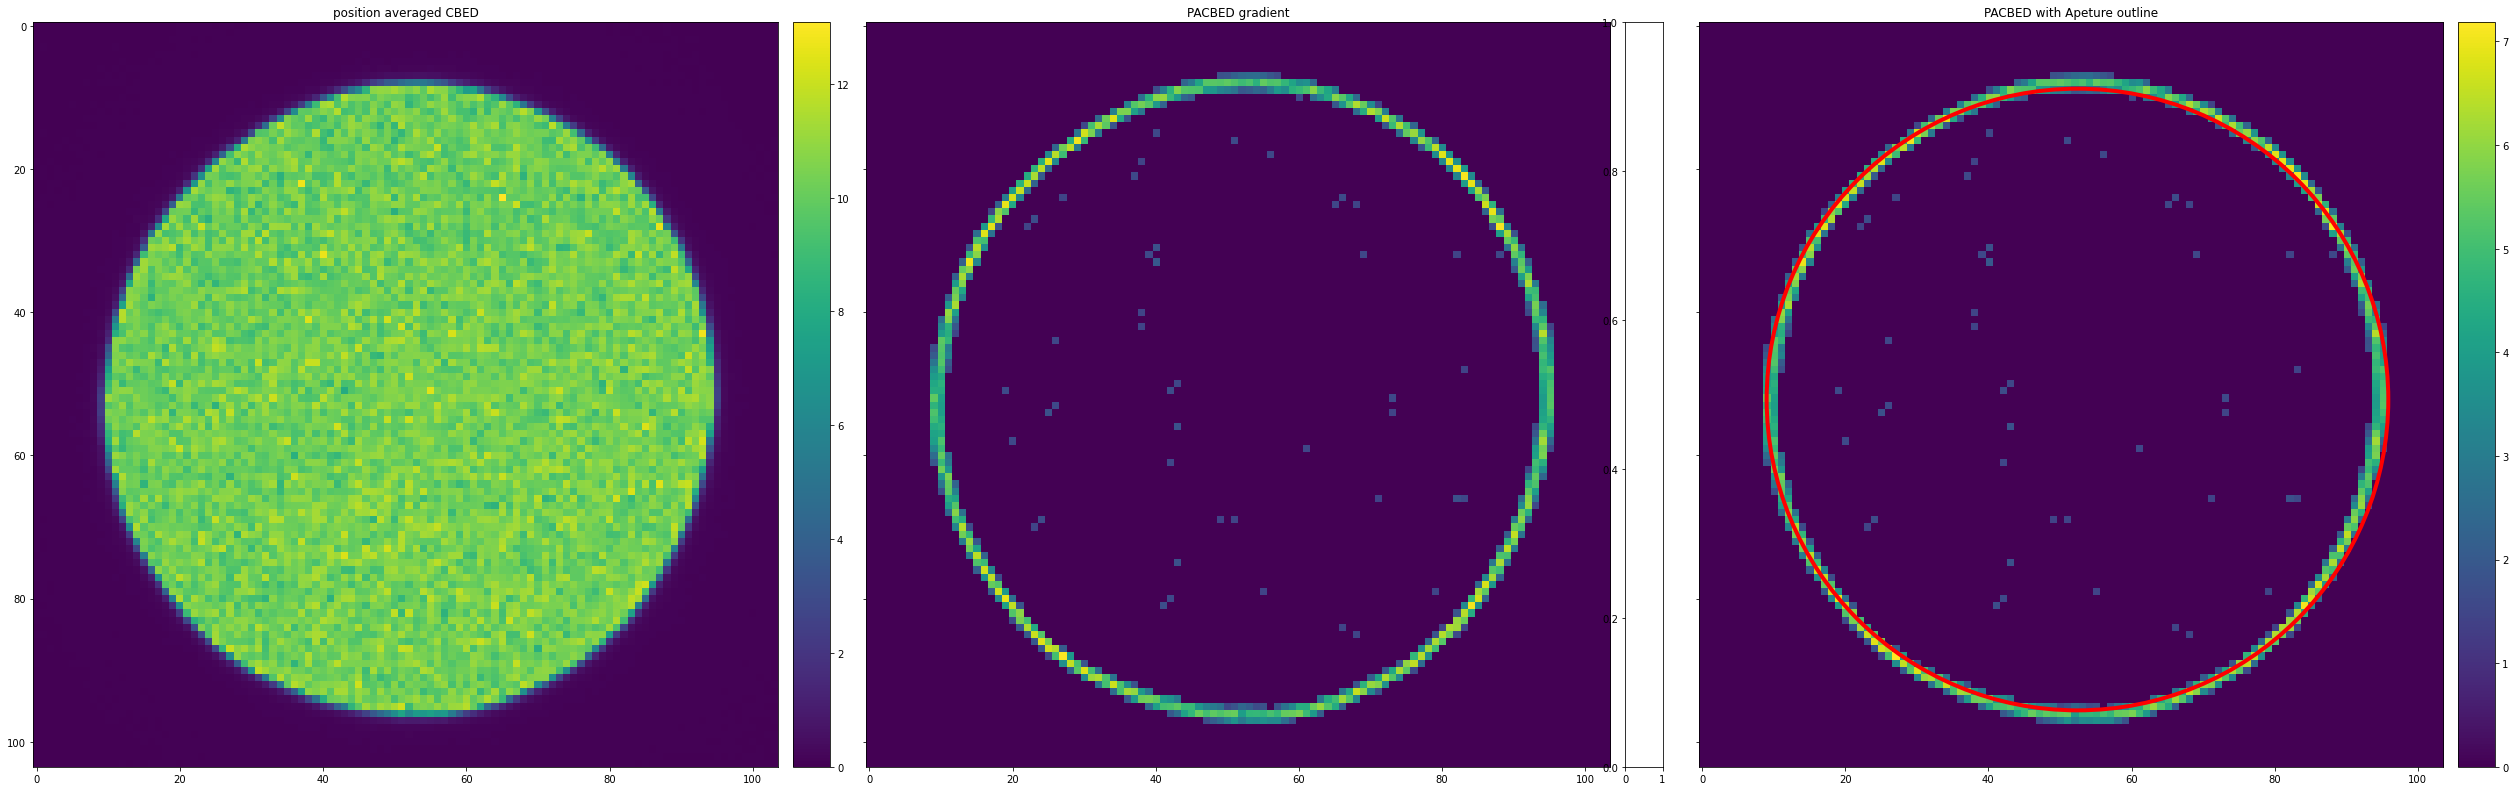

In [9]:
#compute the center of aperture according to determined mask image. 
Y, X = np.indices(pacbed.shape)
x_center, y_center =np.average(pacbed * X), np.average(pacbed * Y)
x_center/=np.average(pacbed)
y_center/=np.average(pacbed)
#get the coarse radius of the aperture if treated as a circule.
radius = np.average(np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)[np.where(pacbed_grad > np.max(pacbed_grad)*thresh)])
#fit the radius and center using circle model.
circle_params = np.asarray([x_center, y_center, radius])
circle_params = optimize.minimize(CircleTarget, circle_params, args=(pacbed_grad, Y, X), method='Nelder-Mead').x
x_center = circle_params[0]
y_center = circle_params[1]
radius = circle_params[2]
oval_params = np.asarray([x_center, y_center, radius, 1.0, 0.0])
oval_params = optimize.minimize(OvalTarget, oval_params, args=(pacbed_grad, Y, X), method='Nelder-Mead').x
#x_center = oval_params[0]
#y_center = oval_params[1]
#radius = oval_params[2]
fig =plt.figure(1, figsize=(150, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(pacbed_grad, cmap=plt.cm.viridis)
grid[1].set_title("PACBED gradient")
im=grid[2].imshow(pacbed_grad, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
circle = patches.Circle((x_center, y_center), radius, fill = False, color="red", linewidth=4)
#circle = patches.Ellipse((x_center, y_center), 2*radius, 2*radius/new_params[3], params[4], fill = False, color="red", linewidth=4)
grid[2].add_patch(circle)
grid[2].set_title("PACBED with Apeture outline")

In [12]:
def DualCircleTarget(params, trotter_grad, radius, x_center, y_center, gridX, gridY):
    dist = params[0]
    angle = params[1]
    centerx1 = x_center + dist*np.cos(angle)
    centery1 = y_center + dist*np.sin(angle)
    centerx2 = x_center - dist*np.cos(angle)
    centery2 = y_center - dist*np.sin(angle)
    #generate a 2D frame for the first center. 
    radius_map1 = np.sqrt((gridX - centerx1)**2 + (gridY - centery1)**2)
    radial_mask1 = np.zeros_like(trotter_grad)
    radial_mask1[np.where(radius_map1<=radius)] = 1.0
    radial_mask1=np.sqrt(np.sum(np.square(np.abs(np.gradient(radial_mask1))), axis =0))
    #generate a 2D frame for the second center. 
    radius_map2 = np.sqrt((gridX - centerx2)**2 + (gridY - centery2)**2)
    radial_mask2 = np.zeros_like(trotter_grad)
    radial_mask2[np.where(radius_map2<=radius)] = 1.0    
    radial_mask2=np.sqrt(np.sum(np.square(np.abs(np.gradient(radial_mask2))), axis =0))
    #generate the mask.
    masked_grad = trotter_grad.copy()
    masked_grad[np.where((radial_mask1 > thresh) | (radial_mask2 > thresh))] = 0.0
    #return the total error.
    return np.sum(masked_grad)
def DualOvalTarget(params, trotter_grad, radius, x_center, y_center, gama, theta, gridX, gridY):
    dist = params[0]
    angle = params[1]
    centerx1 = x_center + dist*np.cos(angle)
    centery1 = y_center + dist*np.sin(angle)
    centerx2 = x_center - dist*np.cos(angle)
    centery2 = y_center - dist*np.sin(angle)
    #generate a 2D frame for the first center. 
    gradX_temp = (gridX - centerx1)*np.cos(angle) - (gridY - centery1)*np.sin(angle)
    gradY_temp = (gridX - centerx1)*np.sin(angle) + (gridY - centery1)*np.cos(angle)
    radius_map1 = np.sqrt(gradX_temp**2 + (gama*gradY_temp)**2)
    radial_mask1 = np.zeros_like(trotter_grad)
    radial_mask1[np.where(radius_map1<=radius)] = 1.0
    radial_mask1=np.sqrt(np.sum(np.square(np.abs(np.gradient(radial_mask1))), axis =0))
    #generate a 2D frame for the second center. 
    gradX_temp = (gridX - centerx2)*np.cos(angle) - (gridY - centery2)*np.sin(angle)
    gradY_temp = (gridX - centerx2)*np.sin(angle) + (gridY - centery2)*np.cos(angle)
    radius_map2 = np.sqrt(gradX_temp**2 + (gama*gradY_temp)**2)
    radial_mask2 = np.zeros_like(trotter_grad)
    radial_mask2[np.where(radius_map2<=radius)] = 1.0    
    radial_mask2=np.sqrt(np.sum(np.square(np.abs(np.gradient(radial_mask2))), axis =0))
    #generate the mask.
    masked_grad = trotter_grad.copy()
    masked_grad[np.where((radial_mask1 > thresh) | (radial_mask2 > thresh))] = 0.0
    #return the total error.
    return np.sum(masked_grad)

In [11]:
trotter_params2 = optimize.minimize(DualCircleTarget, trotter_params, args=(slices_grad, radius, x_center, y_center, X, Y), method='Nelder-Mead').x
print(trotter_params2)

[28.70976262 -1.44739396]


In [13]:
trotter_params3 = optimize.minimize(DualOvalTarget, trotter_params, args=(slices_grad, radius, x_center, y_center, oval_params[3], oval_params[4], X, Y), method='Nelder-Mead').x
print(trotter_params3)

[29.26759923 -1.46646489]
